# **Applying Outer Evaluation** 

## **Requirements**

Here we gather the required libraries, classes and function for this notebook.

In [5]:
import polars as pl
import numpy as np
import os
import sys
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score

`PyImageML` is a Python package that has been developed under this project, which has several utils for plotting images and extracting features from them, features that later could be used along with Machine Learning algorithms to solve typical ML tasks.


In [6]:
sys.path.insert(0, r"C:\Users\fscielzo\Documents\Packages\PyImageML_Package_Private")
from PyImageML.preprocessing import ImageFeaturesExtraction

`PyMachineLearning` is another custom Python package that contains efficient utils to be used in real Machine Learning workflows.

In [7]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\Packages\PyMachineLearning_Package_Private')
from PyMachineLearning.preprocessing import scaler, pca

## **Reading the data**

In this section we are going to read an process the data a little bit.

- `files_list.txt` is a txt file with two 'columns', the first one with the old paths of the images of the data-set, and the second with the images class (neutral (0) or fire (1)).

-  We read `files_list.txt as a data-frame.

- We extract the names of the images files.

- We build a list with the new path of the images.

In [8]:
# Extracting the names of the images files as well as their class/category.
files_list_name = r'C:\Users\fscielzo\Documents\DataScience-GitHub\Image Analysis\Image-Classification\Fire-Detection\files_list.txt'
files_df = pl.read_csv(files_list_name, separator='\t', has_header=False, new_columns=['path', 'class'])
img_files_names = [files_df['path'][i].split('/')[1] for i in range(len(files_df))]

# building a list with the current paths of the data-set images.
img_path_list = []
folder_path = r'C:\Users\fscielzo\Documents\DataScience-GitHub\Image Analysis\Image-Classification\Fire-Detection\Data'
for filename in img_files_names:
    img_path_list.append(os.path.join(folder_path, filename))

## **Defining Response and Predictors**

In this section we define the response and predictors.

- **Predictors:** a list with the paths of the images files.
- **Response:** a vector (1D array) that identify the category of each image.


In [9]:
Y = files_df['class'].to_numpy()
X = img_path_list 

## **Defining the outer validation method**

### **Train-Test Split**

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=123, stratify=Y)

## **Defining the pipelines**

In [11]:
CELLS_PER_BLOCK_HOR = 2
CELLS_PER_BLOCK_VER = 2
PIXELS_PER_CELL_HOR = 8
PIXELS_PER_CELL_VER = 8
orientations = 8
pixels_per_cell=(PIXELS_PER_CELL_HOR, PIXELS_PER_CELL_VER)
cells_per_block=(CELLS_PER_BLOCK_HOR, CELLS_PER_BLOCK_VER)

img_height = 240
img_width = 184

In [12]:
pipelines = {} 

models = {'knn': KNeighborsClassifier(n_jobs=-1), 
          'trees': DecisionTreeClassifier(random_state=123), 
          'extra_trees': ExtraTreesClassifier(random_state=123),
          'RF': RandomForestClassifier(random_state=123), 
          'HGB': HistGradientBoostingClassifier(random_state=123), 
          'MLP': MLPClassifier(random_state=123),
          'LinearSVM': LinearSVC(random_state=123),  
          'XGB': XGBClassifier(random_state=123),
          'Logistic': LogisticRegression(max_iter=250, solver='saga', random_state=123),
          'LGBM': LGBMClassifier(random_state=123, verbose=-1),
          'SVM': SVC(random_state=123)
}

for model_name, model in models.items():

    
    pipelines[model_name] = Pipeline([
                ('feature_extraction', ImageFeaturesExtraction(method='pixels', image_height=img_height, image_width=img_width, convert_to_gray=True, 
                                                               filter='equalized', format='array', orientations=orientations, pixels_per_cell=pixels_per_cell, 
                                                               cells_per_block=cells_per_block, transform_sqrt=True, reshape=False, statistics=None, n_clusters=100)),
                ('scaler', scaler(apply=False, method='standard')),
                ('pca', pca(apply=False, n_components=5, random_state=123)),
                (model_name, model) 
            ])

- **Opening the inner results**

In [13]:
with open(r'C:\Users\fscielzo\Documents\DataScience-GitHub\Image Analysis\Image-Classification\Fire-Detection\Results\inner_score.pkl', 'rb') as file:
    inner_score = pickle.load(file)
with open(r'C:\Users\fscielzo\Documents\DataScience-GitHub\Image Analysis\Image-Classification\Fire-Detection\Results\best_params.pkl', 'rb') as file:
    best_params = pickle.load(file)
with open(r'C:\Users\fscielzo\Documents\DataScience-GitHub\Image Analysis\Image-Classification\Fire-Detection\Results\inner_results.pkl', 'rb') as file:
    inner_results = pickle.load(file)

- Formatting the results

In [14]:
inner_score_values = np.array(list(inner_score.values()))
pipeline_names = list(inner_score.keys())
best_pipeline = pipeline_names[np.argmax(inner_score_values)]
best_model = best_pipeline.split('-')[0]

- Estimation of future performance based on the testing partition:

In [ ]:
best_pipeline_estimator = pipelines[best_model].set_params(**best_params[best_pipeline])
best_pipeline_estimator.fit(X=X_train, y=Y_train)
Y_test_hat = best_pipeline_estimator.predict(X=X_test)
future_performance_acc = accuracy_score(y_pred=Y_test_hat, y_true=Y_test)

The estimation of future performance (accuracy) for the best pipeline is:

In [16]:
np.round(future_performance_acc, 3)

0.987

- Confusion matrix over true classes

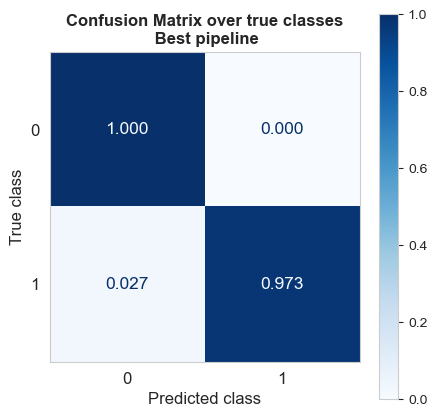

In [17]:
cm = confusion_matrix(y_pred=Y_test_hat, y_true=Y_test, normalize='true', labels=best_pipeline_estimator.classes_)
# normalize='true' to normalize over the rows (true classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_pipeline_estimator.classes_)

fig, axs = plt.subplots(figsize=(5,5))
disp.plot(ax=axs, cmap=plt.cm.Blues, values_format='.3f', text_kw={'fontsize': 12.5})
plt.title('Confusion Matrix over true classes\n Best pipeline', weight='bold', fontsize=12)
axs.set_xlabel('Predicted class', size=12)
axs.set_ylabel('True class', size=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(False)
plt.show()

- All the non-fire images are classified correctly

- The 97.3% of the fire images are detected.

Therefore, in this case:

- Specificity = 100%

- Sensibility/recall = 97%

In [18]:
values, counts = np.unique(Y_test, return_counts=True)
rel_freq = counts / np.sum(counts)
rel_freq

array([0.50666667, 0.49333333])

The accuracy can also be computed with the specificity and sensibility as follows:

In [19]:
1*0.5067 + 0.97*0.493

0.98491

- Confusion matrix over predicted classes

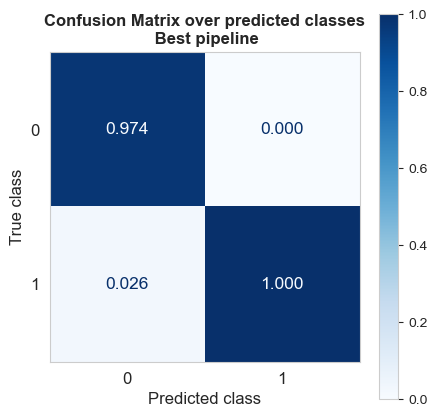

In [20]:
cm = confusion_matrix(y_pred=Y_test_hat, y_true=Y_test, normalize='pred', labels=best_pipeline_estimator.classes_)
# normalize='true' to normalize over the rows (true classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_pipeline_estimator.classes_)

fig, axs = plt.subplots(figsize=(5,5))
disp.plot(ax=axs, cmap=plt.cm.Blues, values_format='.3f', text_kw={'fontsize': 12.5})
plt.title('Confusion Matrix over predicted classes\n Best pipeline', weight='bold', fontsize=12)
axs.set_xlabel('Predicted class', size=12)
axs.set_ylabel('True class', size=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(False)
plt.show()

- The 97.4% of the predicted as non-fire images that are actually non-fire. 

- The 100% of the predicted as fire images are indeed fire.

Therefore, in this case:

- Precision = 100%

- Negative predictive value = 97.4%

The F1-score is the armonic mean between precision and sensibility, and is an ideal metric to measure the performance of a binary classifier on the positive class (fire class in our project), and in this case is:

In [21]:
f1_score(y_pred=Y_test_hat, y_true=Y_test)

0.9863013698630138

Summarizing, our best classifier works almost perfectly, both detecting (classifying) fire and non-fire images.

## **Saving the final pipeline**

We save the best pipeline as a pre-trained model, using all the available dat for training it. 

In [ ]:
best_pipeline_estimator = pipelines[best_model].set_params(**best_params[best_pipeline])
best_pipeline_estimator.fit(X=X, y=Y)
# Save the model to a file
with open(r'C:\Users\fscielzo\Documents\DataScience-GitHub\Image Analysis\Image-Classification\Fire-Detection\Results\best_pipeline.pkl', 'wb') as file:
    pickle.dump(best_pipeline_estimator, file)